In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '.'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

Here we solve time-dependent PDE problem with one spatial dimension and Dirichlet boundary conditions.

Given domain $[0, T] \times [A, B]$, and functions $f(x)$, $g_1(t)$, $g_2(t)$, find such $u(t, x)$ so that

$$\frac{\partial u}{\partial t} = D \frac{\partial^2 u}{\partial x^2}$$
$$u(0, x) = f(x), \quad u(t, A) = g_1(t), \quad u(t, B) = g_2(t)$$

Usually we get boundary conditions as functions, but one of the main features of machine learning is the ability to represent some function using finite training dataset. Let's assume that boundary values are given as finite collection of measurements and stored on disk.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from pinns import Domain
from pinns.samplers import RandomSampler, ConstantSampler, DataSampler

path = './data/diffusion 1d/'

''' -- CONSTRAINTS -- '''

# Case 1: we load constraints in full length to memory.

def get_data(path):
    init = torch.tensor(np.load(path + 'init_data.npy'))
    left = torch.tensor(np.load(path + 'left_data.npy'))
    right = torch.tensor(np.load(path + 'right_data.npy'))
    
    return ([init[:,  :2], left[:,  :2], right[:,  :2]], 
            [init[:, [2]], left[:, [2]], right[:, [2]]])

pts, data = get_data(path)
constraints_sampler = ConstantSampler((pts, data))

# Case 2: if constraints are very large, we may randomly 
# sample subsets of full data each time sampler called.

# paths = [f'./data/{name}_data.npy' for name in ['init', 'left', 'right']]
# constraints_sampler = DataSampler(paths, (16, 12, 8), 2)


''' -- COLLOCATION -- '''

# If our sampler returns tensor with shape [num_pts, num_coords], 
# we must edit our loss function so that it takes not t and x 
# separately, but z instead of shape [1024, 2]. Then we must 
# calculate gradient and use slices to take grad of specific 
# tensors, for example: ```ut = d(u, z)[:, 0]```. But it is very 
# ugly for our demonstration purposes (but much more efficient 
# when number of coordinates is big). We will instead expect 
# from sampler to return dictionary for each coordinate.

domain = Domain({'t': [0, 0.5], 'x': [0, 1]})
collocation_sampler = RandomSampler(domain, 2048)


''' -- VALIDATION DATA -- '''

# We do not want to load all test points every time, so let's 
# write sampler that gives us either all data points or random 
# subset of them. 1024 is pretty much enough to fine precision.

test_data_sampler = DataSampler(path + 'solution.npy', 1024, 2)

Now it's time to write loss function. Remember: we should return tuple of losses, so if you want, for example, multiply loss along each boundary, or multiply sum of boundary losses - you should just be sure that number of returned elements and number of loss coefficients are the same.

In [4]:
from pinns.derivatives import Derivative

d = Derivative(method='autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    D = 0.5
    ):
    
    # We do not need left and right because we are solving 
    # Dirichlet problem and we just compare predictions and 
    # solution. If we solve Cauchy or Robin problem, we 
    # need to calculate derivatives at boundary points.
    
    init_pts, left_pts, right_pts = cstr_pts
    init_pred, left_pred, right_pred = cstr_pred
    init_vals, left_vals, right_vals = cstr_vals
    
    t, x = coll_pts['t'], coll_pts['x']
    
    def initial_loss():
        return torch.mean(torch.square(init_pred - init_vals))
    
    def left_loss():
        return torch.mean(torch.square(left_pred - left_vals))
    
    def right_loss():
        return torch.mean(torch.square(right_pred - right_vals))
    
    def pde_loss(u, t, x):
        ut  = d(u,  t)
        uxx = d(u,  x, orders = 2)
        return torch.mean(torch.square(ut - D * uxx))
    
    return (
        initial_loss(), 
        left_loss(), 
        right_loss(), 
        pde_loss(coll_pred, t, x)
    )

In [22]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Sin
from pinns.optimizers import Adam
from pinns.metrics import rel_l2

pinn = FF([2, 32, 32, 1], activ=nn.Tanh())

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs = [0.75, 0.75, 0.75, 0.25]
)

trainer.train(
    num_iters=2500,
    optimizers=[(0, adam)],
    validate_every=1,
    metrics = [rel_l2],
    test_sampler = test_data_sampler
    )

  0%|          | 0/2500 [00:00<?, ?it/s]

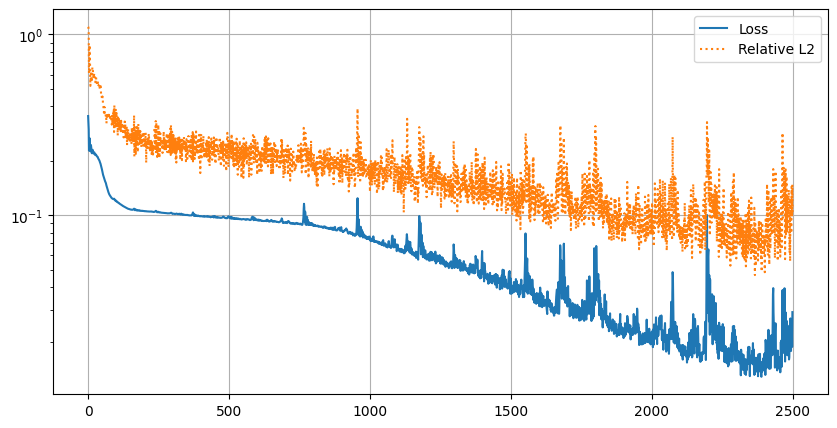

In [23]:
trainer.plot(figsize = (10, 5), single = True)

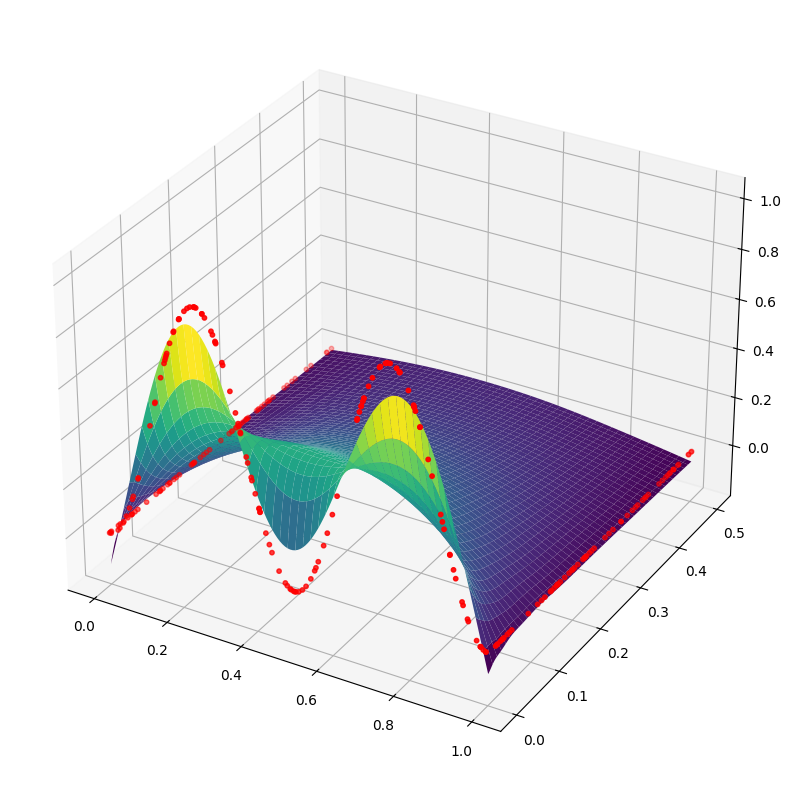

In [27]:
fig = plt.figure(figsize=(10, 10))

# We know the shape of test data.
Nt, Nx = 500, 150
pts, values = test_data_sampler(full=True)

pts = [
    pts[:,0].reshape(Nx, Nt),
    pts[:,1].reshape(Nx, Nt)
]
values = values.reshape(Nx, Nt)

preds = pinn.predict(test_data_sampler(full=True)[0]).detach().reshape(Nx, Nt)
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(pts[1], pts[0], preds, cmap='viridis')

# We also plot constraints as red dots.
cstr_pts, cstr_vals = constraints_sampler()
stacked_pts = torch.cat([torch.hstack([t[:, [1]], t[:, [0]]]) for t in cstr_pts])
stacked_vals = torch.cat(cstr_vals)
constraints = torch.hstack([stacked_pts, stacked_vals.reshape(-1, 1)]).T
ax.scatter3D(*constraints, color='r', s=10)
# ax.view_init(80, -120)

plt.show()